In [ ]:
#import library 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split , RandomizedSearchCV

from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,f1_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.utils.class_weight import compute_sample_weight
from matplotlib import pyplot

In [345]:

#import Data in pandas df
df = pd.read_csv('data/train_tfidf_features.csv')

X, y = df.drop(columns=["id","label"]),df["label"]
#split df into train,test and validation sets
X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.2, random_state=12)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.2, random_state=2)

print(X_train.shape)
print(y_train.shape)

counts = y_train.value_counts()
print(counts)


(10997, 5000)
(10997,)
label
0    6809
1    4188
Name: count, dtype: int64


In [353]:
#Feature Selection with Chi sqaure
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=1000)
X_chi2 = selector.fit_transform(X_train, y_train)
X_val_chi2 = selector.transform(X_val)
X_test_chi2 = selector.transform(X_test)

In [356]:
#perfrorm PCA to reduce features to n = 100 
pca = PCA(n_components=0.9)
pca.fit(X_chi2)
X_pca = pca.transform(X_chi2)
X_test_pca = pca.transform(X_val_chi2)
X_val_pca =  pca.transform(X_test_chi2)
print(X_pca.shape)

(10997, 545)


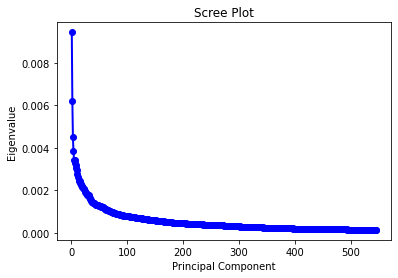

In [357]:
plt.plot(np.arange(1, len(pca.explained_variance_)+1), pca.explained_variance_, 'bo-', linewidth=2)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.show()
# Show PCA graph

In [361]:
#perfrorm LSA to reduce features to n = 200 
from sklearn.decomposition import TruncatedSVD
lsa = TruncatedSVD(n_components=200)  
X_lsa= lsa.fit_transform(X_chi2)
X_test_lsa = lsa.transform(X_test_chi2)
X_val_lsa=  lsa.transform(X_val_chi2)
print(X_lsa.shape)

(10997, 200)


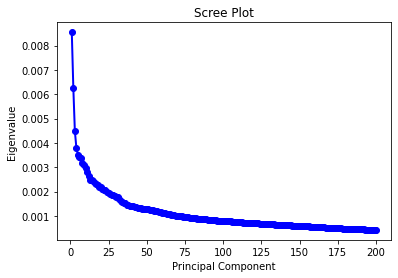

In [362]:
plt.plot(np.arange(1, len(lsa.explained_variance_)+1), lsa.explained_variance_, 'bo-', linewidth=2)
plt.title("Scree Plot")
plt.xlabel("Principal Component")
plt.ylabel("Eigenvalue")
plt.show()
# Show PCA graph

In [383]:
#  base line  Random Forest Model

rc = RandomForestClassifier(random_state=9,n_estimators=100)

print(X_pca.shape,y_train.shape)

rc.fit(X_lsa,y_train)



y_pred = rc.predict(X_test_lsa)

print(classification_report(y_test,y_pred))

(10997, 545) (10997,)
              precision    recall  f1-score   support

           0       0.72      0.82      0.77      2141
           1       0.62      0.48      0.54      1296

    accuracy                           0.69      3437
   macro avg       0.67      0.65      0.66      3437
weighted avg       0.68      0.69      0.68      3437



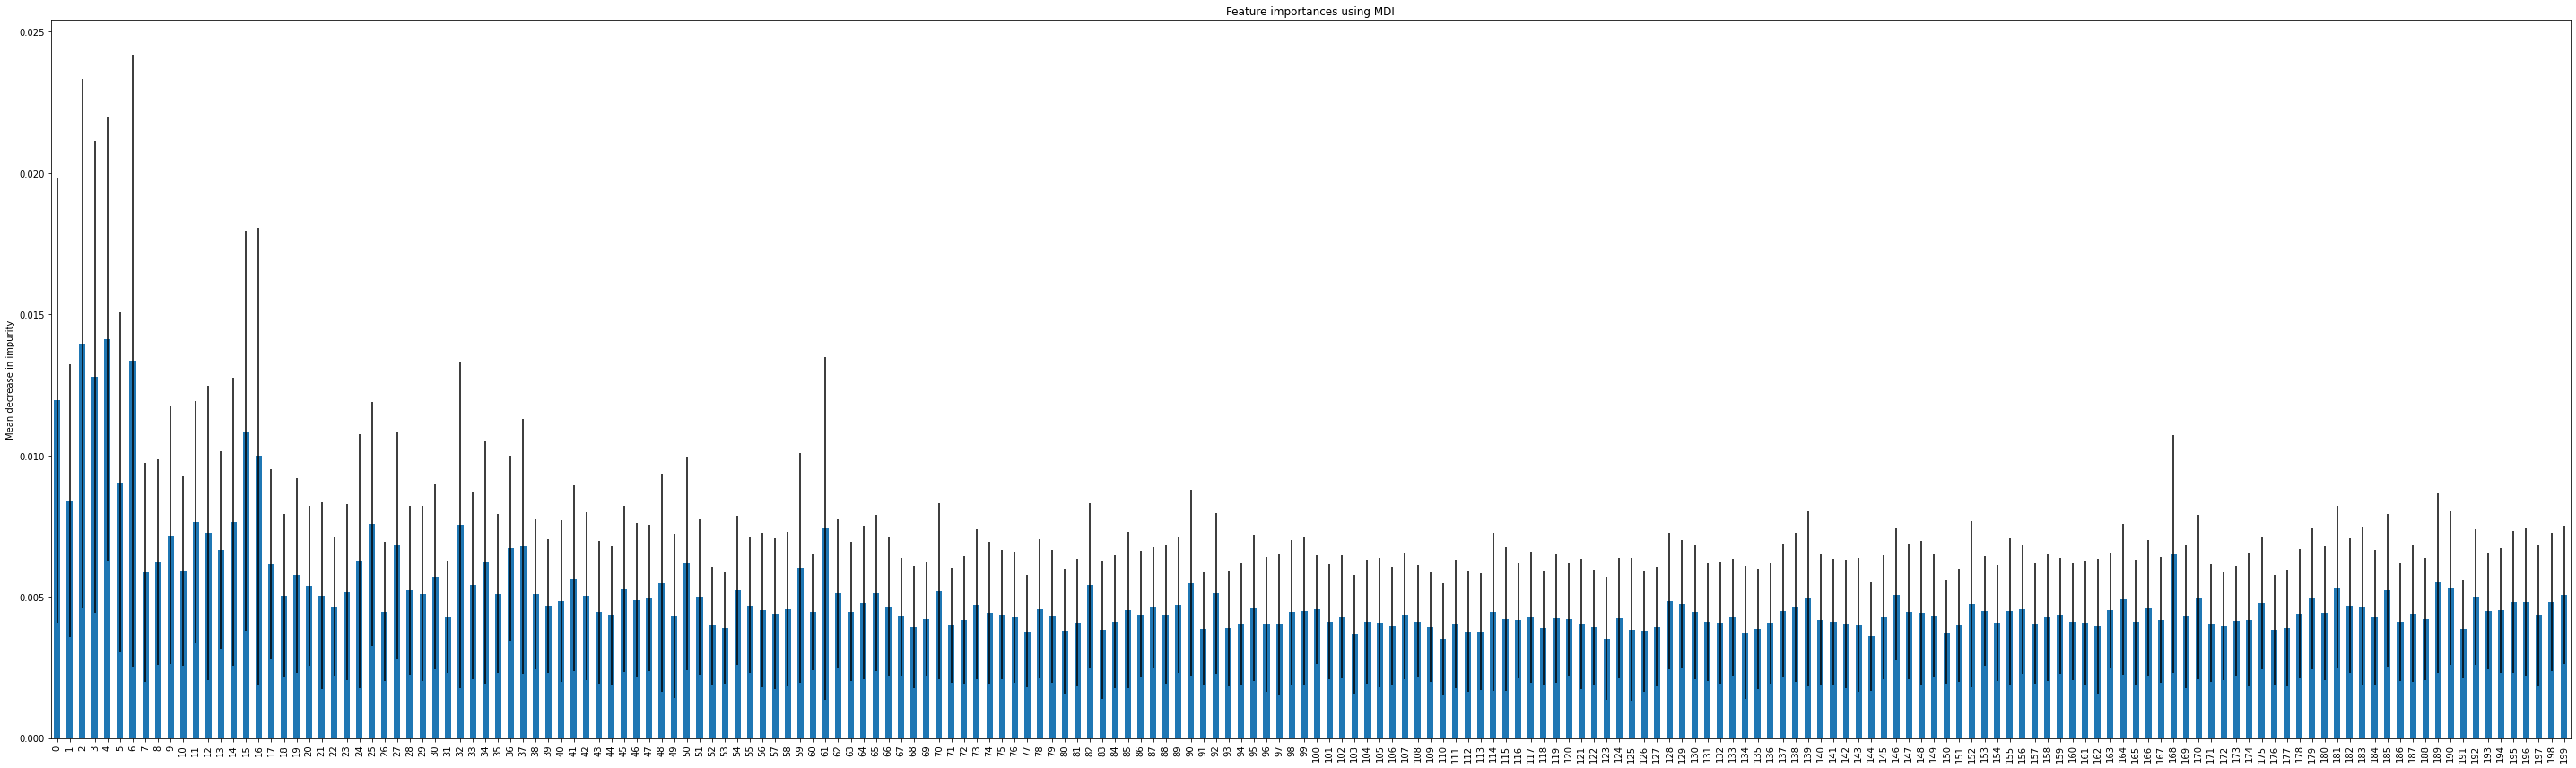

In [384]:
# Feature Importance Graph

importances = rc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rc.estimators_], axis=0)
forest_importances = pd.Series(importances)

fig, ax = plt.subplots(figsize=(40, 12))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
plt.show()

In [389]:

top20_idx = np.argsort(importances)[::-1][:20]

X_train_top20 = X_lsa[:, top20_idx]

X_test_top20 = X_test_lsa[:, top20_idx]

In [395]:
selected_rc = RandomForestClassifier(random_state=123,n_estimators=100)

print(X_pca.shape,y_train.shape)

selected_rc.fit(X_train_top20,y_train)



y_pred = selected_rc.predict(X_test_top20)

print(classification_report(y_test,y_pred))

(10997, 545) (10997,)
              precision    recall  f1-score   support

           0       0.73      0.79      0.76      2141
           1       0.60      0.51      0.55      1296

    accuracy                           0.69      3437
   macro avg       0.67      0.65      0.66      3437
weighted avg       0.68      0.69      0.68      3437



# Optimizing Model

(10997, 20)


In [396]:
# Calculating Class-weight in train data set
counts = y_train.value_counts()

class_weights = {0: sum(counts) / counts[0] , 1: sum(counts) / counts[1]}

print(class_weights)

{0: np.float64(1.615068291966515), 1: np.float64(2.6258357211079275)}


In [405]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier( )

model.fit(X_train_top20, y_train)
predictions = model.predict(X_test_top20)
test_acc = f1_score(y_test, predictions)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.71      0.84      0.77      2141
           1       0.63      0.44      0.52      1296

    accuracy                           0.69      3437
   macro avg       0.67      0.64      0.64      3437
weighted avg       0.68      0.69      0.68      3437



In [ ]:
sample_weight = compute_sample_weight(class_weight='balanced', y=y_train)
param_grid = {
    'max_features': [None, 2, 5, 10, 20],
    'max_depth': [1, 2, 3, 5, 8, 10, 12,15],
    'min_samples_leaf': [1, 5, 10, 20, 30, 50],
    'n_estimators': [10, 25, 50, 100, 200, 300, 500],
    'subsample': [0.8],
    'learning_rate': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
}
GBC = GradientBoostingClassifier(random_state=123)
grid_search = RandomizedSearchCV (GBC, param_distributions=param_grid, cv=5 ,n_jobs=-1,scoring="f1",n_iter= 100 )
grid_search.fit(X_train_top20, y_train,sample_weight=sample_weight)
print("prams tested : mean test score ; rank")
for i in range(len(grid_search.cv_results_["params"])):
    print("{}: {} ; {}".format( grid_search.cv_results_["params"][i] , grid_search.cv_results_["mean_test_score"][i], grid_search.cv_results_["rank_test_score"][i]))

prams tested : mean test score ; rank


TypeError: unhashable type: 'dict'

In [398]:
for i in range(len(grid_search.cv_results_["params"])):
    print("{}: {} ; {}".format( grid_search.cv_results_["params"][i] , grid_search.cv_results_["mean_test_score"][i], grid_search.cv_results_["rank_test_score"][i]))

{'subsample': 1.0, 'n_estimators': 50, 'min_samples_leaf': 30, 'max_features': 70, 'max_depth': 5, 'learning_rate': 0.2}: 0.620417643984263 ; 11
{'subsample': 1.0, 'n_estimators': 200, 'min_samples_leaf': 30, 'max_features': None, 'max_depth': 15, 'learning_rate': 0.05}: 0.6004796577878582 ; 43
{'subsample': 0.8, 'n_estimators': 300, 'min_samples_leaf': 20, 'max_features': 10, 'max_depth': 8, 'learning_rate': 0.2}: 0.5677337474575542 ; 76
{'subsample': 0.8, 'n_estimators': 100, 'min_samples_leaf': 10, 'max_features': 100, 'max_depth': 1, 'learning_rate': 0.005}: 0.5436304198787767 ; 96
{'subsample': 0.9, 'n_estimators': 500, 'min_samples_leaf': 1, 'max_features': 50, 'max_depth': 12, 'learning_rate': 0.1}: 0.5529507427221811 ; 90
{'subsample': 0.8, 'n_estimators': 500, 'min_samples_leaf': 30, 'max_features': 20, 'max_depth': 2, 'learning_rate': 0.001}: 0.5663847059795638 ; 77
{'subsample': 0.6, 'n_estimators': 10, 'min_samples_leaf': 100, 'max_features': 20, 'max_depth': 8, 'learning_r

In [399]:

predictions = grid_search.predict(X_test_top20)
print(classification_report(y_test,predictions))

predictions = grid_search.predict(X_train_top20)
print(classification_report(y_train,predictions))

              precision    recall  f1-score   support

           0       0.77      0.67      0.72      2141
           1       0.55      0.68      0.61      1296

    accuracy                           0.67      3437
   macro avg       0.66      0.67      0.66      3437
weighted avg       0.69      0.67      0.68      3437

              precision    recall  f1-score   support

           0       0.88      0.77      0.82      6809
           1       0.69      0.83      0.76      4188

    accuracy                           0.79     10997
   macro avg       0.79      0.80      0.79     10997
weighted avg       0.81      0.79      0.80     10997



In [470]:
Best_parms = {'subsample': 0.7, 'n_estimators': 200, 'min_samples_leaf': 30, 'max_features': 5, 'max_depth': 15, 'learning_rate': 0.001, 'n_iter_no_change' :5 } # added Min_sample split to reduce overfitting
Best_model = GradientBoostingClassifier(**Best_parms)

Best_model.fit(X_lsa, y_train,sample_weight=sample_weight)
predictions = Best_model.predict(X_test_lsa)
print("Test Data Set:")
print(classification_report(y_test,predictions))

predictions = Best_model.predict(X_lsa)
print("Test Data Set:")
print(classification_report(y_train,predictions))

Test Data Set:
              precision    recall  f1-score   support

           0       0.79      0.69      0.74      2141
           1       0.58      0.69      0.63      1296

    accuracy                           0.69      3437
   macro avg       0.68      0.69      0.68      3437
weighted avg       0.71      0.69      0.70      3437

Test Data Set:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84      6809
           1       0.71      0.84      0.77      4188

    accuracy                           0.81     10997
   macro avg       0.80      0.82      0.80     10997
weighted avg       0.82      0.81      0.81     10997



In [471]:
from sklearn import svm 

SVM = svm.SVC(kernel='linear',class_weight= "balanced")
SVM.fit(X_lsa, y_train)
predictions = SVM.predict(X_test_lsa)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.76      0.76      0.76      2141
           1       0.60      0.59      0.60      1296

    accuracy                           0.70      3437
   macro avg       0.68      0.68      0.68      3437
weighted avg       0.70      0.70      0.70      3437



In [472]:

SVM = svm.LinearSVC(class_weight= "balanced")
SVM.fit(X_chi2, y_train)
predictions = SVM.predict(X_test_chi2)
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.79      0.76      0.77      2141
           1       0.63      0.67      0.65      1296

    accuracy                           0.72      3437
   macro avg       0.71      0.71      0.71      3437
weighted avg       0.73      0.72      0.73      3437



In [ ]:
from sklearn.linear_model import LogisticRegressionCV   

clf = LogisticRegressionCV(cv=5, random_state=0).fit(X_lsa, y_train)
predictions = clf.predict(X_test_lsa)

print(classification_report(y_test,predictions))

[[0.34623787 0.65376213]
 [0.03048941 0.96951059]
 [0.84565895 0.15434105]
 ...
 [0.51925753 0.48074247]
 [0.64523115 0.35476885]
 [0.71082893 0.28917107]]
              precision    recall  f1-score   support

           0       0.72      0.85      0.78      2141
           1       0.65      0.46      0.54      1296

    accuracy                           0.70      3437
   macro avg       0.69      0.66      0.66      3437
weighted avg       0.70      0.70      0.69      3437



In [ ]:

Best_parms = {'subsample': 0.7, 'n_estimators': 200, 'min_samples_leaf': 30, 'max_features': 5, 'max_depth': 15, 'learning_rate': 0.001, 'n_iter_no_change' :5 } # added Min_sample split to reduce overfitting

LSVC = svm.LinearSVC(class_weight= "balanced").fit(X_chi2, y_train)
SVC = svm.SVC(kernel='linear',class_weight= "balanced",probability =True).fit(X_lsa, y_train)
GBC = GradientBoostingClassifier(**Best_parms).fit(X_train_top20, y_train,sample_weight=sample_weight)
LR = LogisticRegressionCV(cv=5).fit(X_lsa, y_train)




def stack_pred(top20,chi2,lsa):
    model_stack  = [SVC,GBC,LR]
    predictions = []
    model_weights = 1
    for sample_index in range(len(top20)):
        sample_prob= [0,0]
        stack_prob = [SVC.predict_proba(X_lsa[sample_index].reshape(1, -1))[0] , 
                        GBC.predict_proba(X_train_top20[sample_index].reshape(1, -1))[[0]] ,
                        LR.predict_proba(X_lsa[sample_index].reshape(1, -1))[[0]] ]
        for prob in stack_prob:
            print(prob)
            sample_prob[0] += prob[0]
            sample_prob[1] += prob[1]
        print(sample_prob)
        if sample_prob[0][0]/3> sample_prob[0][1]/3:
            predictions.append(0)
        else:
            predictions.append(1)
    return predictions
        
prediction = stack_pred(X_test_top20,X_test_chi2,X_test_lsa)
print(classification_report(y_test,predictions))
        

IndexError: index 1 is out of bounds for axis 0 with size 1

In [504]:

index = 1111
print(SVC.predict_proba(X_lsa[index].reshape(1, -1))[0])
print(LR.predict_proba(X_lsa[index].reshape(1, -1))[0])
print(GBC.predict_proba(X_train_top20[index].reshape(1, -1))[0])
print(y_train.iloc[index])

[0.74834585 0.25165415]
[0.71082893 0.28917107]
[0.54243144 0.45756856]
0
